| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

#### This notebook is licensed under GPL 3.0. Please visit our Github repo for more information: 
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following our authorship protocol: https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/
#### For more information about this project, visit https://www.environmentalenforcementwatch.org/

## How to Run this Notebook
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

# Watershed statistics from ECHO

Here we load some helper code to get us going. If your environment already has these loaded this cell may be skipped. (If you're not sure, it's best to run this cell!)

In [1]:
# We have a folder of chunks of reusable code that we're using across different
#  Notebooks. This step goes and gets the relevant code from that folder so we
#  can use it here. (https://github.com/edgi-govdata-archiving/ECHO_modules/tree/watershed-geo)
!git clone https://github.com/edgi-govdata-archiving/ECHO_modules.git -b watershed-geo

# Geopandas is an open source library for working with geographic data using the
#   data structures library "pandas" (common in Python for data processing).
#   (https://geopandas.org/)
!pip install geopandas

# Topojson is an open source library that lets us keep file sizes small when
#   working with geographic data, so the Notebooks can run faster while still
#   working with detailed shapes. (https://github.com/mattijn/topojson)
!pip install topojson

# This code block will print a lot of data as it fetches and installs the libraries
#   Specified above. When it's done, the line below lets us know by printing "Done!"
print("Done!")

Cloning into 'ECHO_modules'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 176 (delta 93), reused 113 (delta 52), pack-reused 0
Receiving objects: 100% (176/176), 74.69 KiB | 6.22 MiB/s, done.
Resolving deltas: 100% (93/93), done.
     |████████████████████████████████| 1.0MB 5.8MB/s 
     |████████████████████████████████| 14.8MB 262kB/s 
     |████████████████████████████████| 6.5MB 32.5MB/s 
     |████████████████████████████████| 81kB 3.3MB/s 
Done!


This cell must be run to bring in some utility functions.

In [3]:
# The previous step installed the libraries (explained above); this tells our
#   Notebook how to refer to them.
import geopandas as geopandas
import topojson as tp

# These code blocks come from our folder (https://github.com/edgi-govdata-archiving/ECHO_modules/blob/watershed-geo/make_data_sets.py)
# Each of the files contains a series of function definitions. By running
#   those files here, we make the functions available in this Notebook.
%run ECHO_modules/DataSet.py
%run ECHO_modules/utilities.py
%run ECHO_modules/make_data_sets.py
print("Done!")

Done!


Select the state you want to look more closely at.  Multiple states may be selected, but this should be used judiciously as it can greatly increase the amount of data and the time to load it.
Ctrl + Click adds to the current selection.  Shift + Click extends the selection.

In [6]:
# From our folder, get some geographic data, in this case a list of states
from ECHO_modules import geographies

# Create a widget that can be used to select a state
states_w = widgets.SelectMultiple(
    options=states,
    description='State:',
    disabled=False,
)
# Display the widget (below)
states_w

SelectMultiple(description='State:', options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA'…

Run this cell to load watershed data. It may take some time depending on the state you're looking at!

In [7]:
# In this cell, we are building a query using the SQL language so we can get
#   information from the database about the places we're interested in

# Use the selections from the state-selecting widget from the previous block
#   to create a list of the states we're interested in
states_selected = ' WHERE'
for st in states_w.value:
    states_selected += ' "states" LIKE \'%'+st+'%\' OR'
states_selected = states_selected[:-3]

# Load data from the Stony Brook University mirror of EPA's ECHO database
# https://gis.stackexchange.com/questions/112057/sql-query-to-have-a-complete-geojson-feature-from-postgis

# This builds the query by appending details about our request to the variable "sql"
sql = """
    SELECT jsonb_build_object(
        'type', 'FeatureCollection', 'features', jsonb_agg(features.feature)
    )
    FROM (
        SELECT jsonb_build_object(
            'type', 'Feature','id', gid, 'geometry',
            ST_AsGeoJSON(geom)::jsonb,'properties',
            to_jsonb(inputs) - 'gid' - 'geom'
        ) AS feature
        FROM (
            SELECT *
            FROM "wbdhu8"
"""
sql += states_selected
sql += """
        ) inputs
    ) features;
"""

# The URL here is the location of the database we're requesting from
url= 'http://portal.gss.stonybrook.edu/echoepa/index2.php?query=' # Old server: 'http://apps.tlt.stonybrook.edu/echoepa/index2.php?query='
data_location=url+urllib.parse.quote_plus(sql) + '&pg'
print(sql) # For debugging
print(data_location) # For debugging

# Here, we check to make sure we can read the data we got back
gdf=None
try:
  gdf = geopandas.read_file(data_location)
  print("Data loaded. Now to map it!")
except:
  print('Something went wrong!')


    SELECT jsonb_build_object(
        'type', 'FeatureCollection', 'features', jsonb_agg(features.feature)
    )
    FROM (
        SELECT jsonb_build_object(
            'type', 'Feature','id', gid, 'geometry',
            ST_AsGeoJSON(geom)::jsonb,'properties',
            to_jsonb(inputs) - 'gid' - 'geom'
        ) AS feature
        FROM (
            SELECT *
            FROM "wbdhu8"
 WHERE "states" LIKE '%WA%'
        ) inputs
    ) features;

http://portal.gss.stonybrook.edu/echoepa/index2.php?query=%0A++++SELECT+jsonb_build_object%28%0A++++++++%27type%27%2C+%27FeatureCollection%27%2C+%27features%27%2C+jsonb_agg%28features.feature%29%0A++++%29%0A++++FROM+%28%0A++++++++SELECT+jsonb_build_object%28%0A++++++++++++%27type%27%2C+%27Feature%27%2C%27id%27%2C+gid%2C+%27geometry%27%2C%0A++++++++++++ST_AsGeoJSON%28geom%29%3A%3Ajsonb%2C%27properties%27%2C%0A++++++++++++to_jsonb%28inputs%29+-+%27gid%27+-+%27geom%27%0A++++++++%29+AS+feature%0A++++++++FROM+%28%0A++++++++++++SELECT+%2A%0A++

Map the watersheds in this state. It may take some time depending on the state you're looking at! It may also "disconnect" if there are a lot of watersheds. Still, you can just skip to the next step ("Pick a specific watershed...")

In [8]:
# Load map data
import json

x = tp.Topology(gdf, toposimplify=.01) # Simplify and topologize the watershed boundaries in order to reduce the file size
x = x.to_json() # save as topojson
y = json.loads(x) # load as json

# create the map using a library called Folium (https://github.com/python-visualization/folium)
m = folium.Map()
w = folium.TopoJson(
    y,
    'objects.data',
    name = "Watersheds",
).add_to(m)
folium.GeoJsonTooltip(fields=["name"]).add_to(w)

# compute boundaries so that the map automatically zooms in
b1 = [list(gdf.total_bounds)[1],list(gdf.total_bounds)[0]]
b2 = [list(gdf.total_bounds)[3],list(gdf.total_bounds)[2]]
bounds = [b1,b2] #m.fit_bounds([[52.193636, -2.221575], [52.636878, -1.139759]])
m.fit_bounds(bounds)

# display the map!
display(m)

Pick specific watersheds. Ctrl+click to add to the selection, Shift+click to extend the selection.

In [9]:
try :
    gdf.set_index("name", inplace=True) # Edit to not alter the gdf
except KeyError:
    # If the cell is run twice the index is already set and "name" is not available
    pass

# Find the "HUC" codes, which are a proxy the EPA uses for watersheds, in the regions of interest  
hucs = gdf.index.unique()

# Set up a widget for selecting watersheds of interest
watershed_w = widgets.SelectMultiple(
    options= hucs.sort_values(),
    description='Watershed:',
    disabled=False,
)

# Display the widget
watershed_w

SelectMultiple(description='Watershed:', options=('Banks Lake', 'Chief Joseph', 'Clearwater', "Coeur d'Alene L…

Get basic information about facilities in this watershed

In [11]:
# Create a list of every HUC and every ID in the selected watershed(s)
hucs = []
id_string = ""
for x in watershed_w.value:
    huc = gdf.at[ x, "huc8" ]
    huc = float( huc )
    hucs.append( huc )
    id_string += str( huc ) + ','

# Create a SQL query to get information about those watersheds from the database    
sql = 'select * from "ECHO_EXPORTER" where "FAC_ACTIVE_FLAG" = \'Y\' and "FAC_DERIVED_HUC" in (' \
        + id_string[:-1] + ')'

# Fetch the relevant data from the database (use the SQL query)
try:
    # Don't index.
    full_echo_data = get_data( sql )
except pd.errors.EmptyDataError:
    print("\nThere are no EPA facilities for this query.\n")

# Print the data
full_echo_data    

select * from "ECHO_EXPORTER" where "FAC_ACTIVE_FLAG" = 'Y' and "FAC_DERIVED_HUC" in (17110011.0)
http://portal.gss.stonybrook.edu/echoepa/?query=select+%2A+from+%22ECHO_EXPORTER%22+where+%22FAC_ACTIVE_FLAG%22+%3D+%27Y%27+and+%22FAC_DERIVED_HUC%22+in+%2817110011.0%29&pg


,REGISTRY_ID,FAC_NAME,FAC_STREET,FAC_CITY,FAC_STATE,FAC_ZIP,FAC_COUNTY,FAC_FIPS_CODE,FAC_EPA_REGION,FAC_INDIAN_CNTRY_FLG,FAC_FEDERAL_FLG,FAC_US_MEX_BORDER_FLG,FAC_CHESAPEAKE_BAY_FLG,FAC_NAA_FLAG,FAC_LAT,FAC_LONG,FAC_MAP_ICON,FAC_COLLECTION_METHOD,FAC_REFERENCE_POINT,FAC_ACCURACY_METERS,FAC_DERIVED_TRIBES,FAC_DERIVED_HUC,FAC_DERIVED_WBD,FAC_DERIVED_STCTY_FIPS,FAC_DERIVED_ZIP,FAC_DERIVED_CD113,FAC_DERIVED_CB2010,FAC_PERCENT_MINORITY,FAC_POP_DEN,FAC_MAJOR_FLAG,FAC_ACTIVE_FLAG,FAC_MYRTK_UNIVERSE,FAC_INSPECTION_COUNT,FAC_DATE_LAST_INSPECTION,FAC_DAYS_LAST_INSPECTION,FAC_INFORMAL_COUNT,FAC_DATE_LAST_INFORMAL_ACTION,FAC_FORMAL_ACTION_COUNT,FAC_DATE_LAST_FORMAL_ACTION,FAC_TOTAL_PENALTIES,...,RCRA_INFORMAL_COUNT,RCRA_FORMAL_ACTION_COUNT,RCRA_DATE_LAST_FORMAL_ACTION,RCRA_PENALTIES,RCRA_LAST_PENALTY_DATE,RCRA_LAST_PENALTY_AMT,RCRA_QTRS_WITH_NC,RCRA_COMPLIANCE_STATUS,RCRA_SNC_FLAG,RCRA_3YR_COMPL_QTRS_HISTORY,SDWA_IDS,SDWA_SYSTEM_TYPES,SDWA_INFORMAL_COUNT,SDWA_FORMAL_ACTION_COUNT,SDWA_COMPLIANCE_STATUS,SDWA_SNC_FLAG,TRI_IDS,TRI_RELEASES_TRANSFERS,TRI_ON_SITE_RELEASES,TRI_OFF_SITE_TRANSFERS,TRI_REPORTER_IN_PAST,FEC_CASE_IDS,FEC_NUMBER_OF_CASES,FEC_LAST_CASE_DATE,FEC_TOTAL_PENALTIES,GHG_IDS,GHG_CO2_RELEASES,DFR_URL,FAC_SIC_CODES,FAC_NAICS_CODES,FAC_DATE_LAST_INSPECTION_EPA,FAC_DATE_LAST_INSPECTION_STATE,FAC_DATE_LAST_FORMAL_ACT_EPA,FAC_DATE_LAST_FORMAL_ACT_ST,FAC_DATE_LAST_INFORMAL_ACT_EPA,FAC_DATE_LAST_INFORMAL_ACT_ST,FAC_FEDERAL_AGENCY,TRI_REPORTER,FAC_IMP_WATER_FLG,EJSCREEN_FLAG_US
0,110070383928,BRAVEN METALS,UNSPECIFIED,MARYSVILLE,WA,98271,NaN,53061,10,N,NaN,NaN,NaN,N,48.118713,-122.176476,CWA-NC-MN-N.png,GPS - UNSPECIFIED,POINT WHERE SUBSTANCE IS RELEASED,10,"Tulalip Tribes of Washington - .4 mile(s), Sti...",17110011,171100110204,53061,98271,2.0,530610528032038,21.980,1052.56,NaN,Y,NNN,0,NaN,NaN,0,NaN,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://echo.epa.gov/detailed-facility-report?f...,1794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,110070504646,CASCADIA MARYSVILLE,11013 STATE AVE,MARYSVILLE,WA,98271,NaN,53061,10,N,NaN,NaN,NaN,N,48.094753,-122.173126,CWA-NC-MN-N.png,GPS - UNSPECIFIED,POINT WHERE SUBSTANCE IS RELEASED,10,"Tulalip Tribes of Washington - .1 mile(s), Tul...",17110011,171100110204,53061,98271,2.0,530610528053007,23.813,1590.22,NaN,Y,NNN,0,NaN,NaN,0,NaN,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://echo.epa.gov/detailed-facility-report?f...,1794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N
2,110005346410,OLYMPIC FORD OF MARYSVILLE,3520 136TH NE,MARYSVILLE,WA,98271,SNOHOMISH,53061,10,Y,NaN,NaN,NaN,N,48.118510,-122.183650,RCRA-IC-MN-N.png,ADDRESS MATCHING-HOUSE NUMBER,CENTER OF A FACILITY OR STATION,30,"Tulalip Tribes of Washington - 0 mile(s), Stil...",17110011,171100110204,53061,98271,2.0,530610528032048,22.215,1025.72,NaN,Y,NNN,0,11/28/1999,7763.0,0,NaN,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Violation Identified,N,____________,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://echo.epa.gov/detailed-facility-report?f...,NaN,44111,NaN,11/28/1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,110070081217,APPLIANCE RECYCLING OUTLET,10105 AIRPORT WAY,SNOHOMISH,WA,98296,SNOHOMISH COUNTY,53061,10,N,NaN,NaN,NaN,N,47.905490,-122.098650,CWA-NC-MN-3.png,ADDRESS MATCHING-HOUSE NUMBER,CENTER OF A FACILITY OR STATION,30,"Tulalip Tribes of Washington - 9.8 mile(s), Tu...",17110011,171100110203,53061,98296,1.0,530610521051026,16.401,684.96,NaN,Y,NNN,2,12/20/2018,801.0,0,NaN,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://echo.epa.gov/detailed-facility-report?f...,5093,423930,NaN,12/20/2018,NaN,NaN,NaN,NaN,NaN,NaN,Y,N
4,110070598230,PUGET PARK TOWNHOMES,UNSPECIFIED,SNOHOMISH,WA,98296,NaN,53061,10,N,NaN,NaN,NaN,N,47.861305,-122.133544,CWA-SNC-MN-N.png,NaN,NaN,17533,"Tulalip Tribes of Washington - 12 mile(

Map these facilities.

In [13]:
# Create a map of the facilities in the specified watershed area(s) using Folium
if ( full_echo_data is not None ):
    map_of_facilities = mapper(full_echo_data) # Some errors not caught here...
    this_watershed = gdf.loc[gdf.index.isin( watershed_w.value )]
    w = folium.GeoJson(
      this_watershed,
      name = "Watershed",
    ).add_to(map_of_facilities)
    display( map_of_facilities ) 
else:
    print( "There are no facilities in the watershed." ) 

Are the facilities complying with the Clean Water Act? Top violators over the past 13 quarters.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


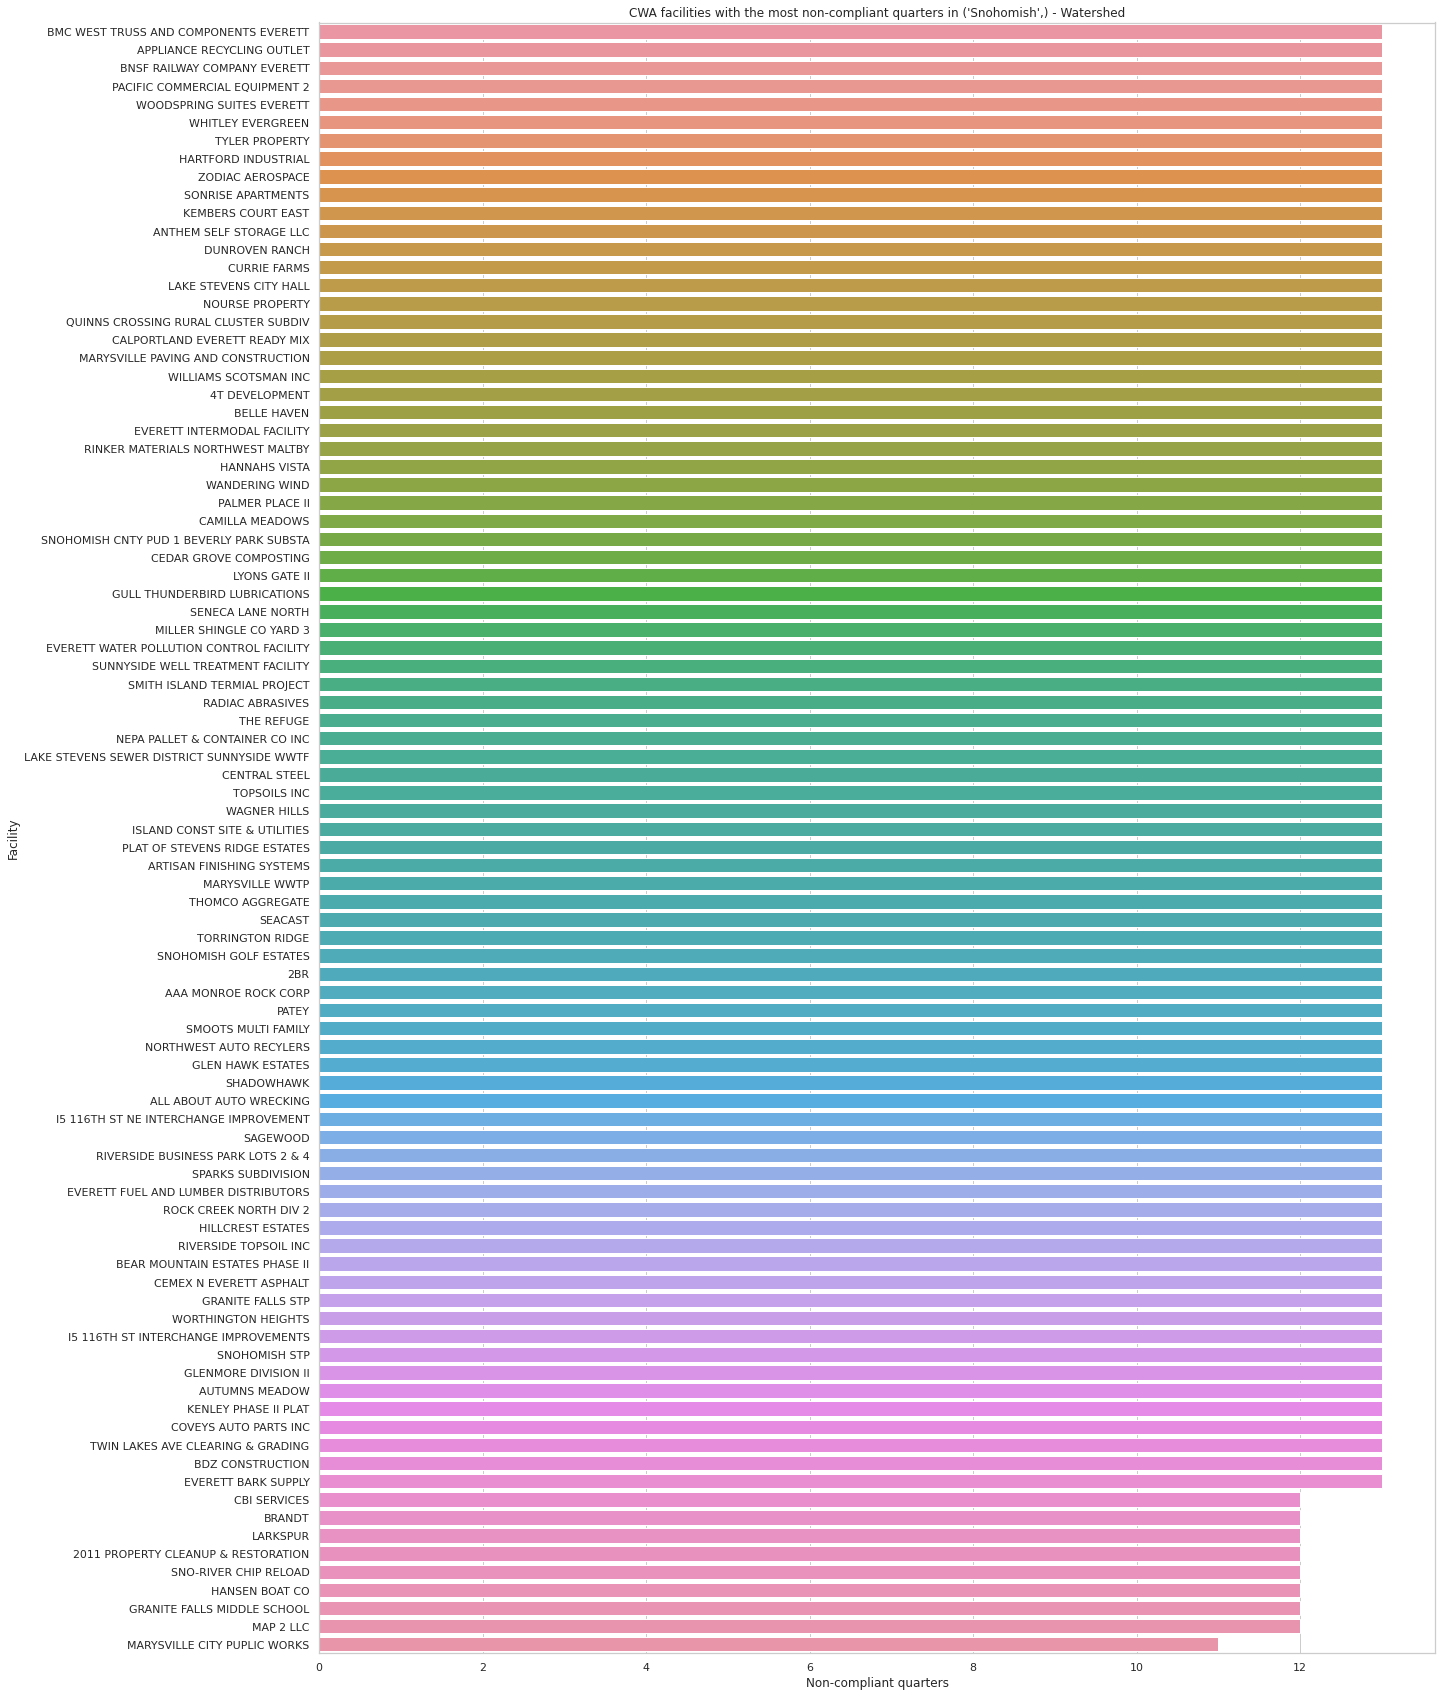

In [16]:
# Use the function get_top_violators from our imported utilities.py file (https://github.com/edgi-govdata-archiving/ECHO_modules/blob/watershed-geo/utilities.py)
df_violators = get_top_violators( full_echo_data, 'NPDES_FLAG', watershed_w.value, "Watershed", 
        'CWA_13QTRS_COMPL_HISTORY', 'CWA_FORMAL_ACTION_COUNT', 90 )
display( chart_top_violators( df_violators, watershed_w.value, "Watershed", 'CWA' ))

Get more detailed, program-specific data for these facilities (e.g. longer-term historical [non]compliance with the Clean Water Act). First, select the program.

In [17]:
# Define the data sets we're interested in learning about
data_set_list = ['CWA Violations', 'CWA Inspections', 'CWA Penalties', 
                 '2020 Discharge Monitoring',] 

# Use the function make_data_sets (imported from https://github.com/edgi-govdata-archiving/ECHO_modules/blob/watershed-geo/make_data_sets.py)
data_sets = make_data_sets( data_set_list )

# Use the function show_data_set_widget (imported from https://github.com/edgi-govdata-archiving/ECHO_modules/blob/watershed-geo/utilities.py)
data_set_widget = show_data_set_widget( data_sets ) 

#Note: we might consider limiting to CWA/SDWA given the watershed-focus of this notebook

Dropdown(description='Data sets:', options=('CWA Violations', 'CWA Inspections', 'CWA Penalties', '2020 Discha…

Get the data from the Stony Brook University database. 

In [20]:
# Use the selection from the widget above to save data from that program
program = data_sets[ data_set_widget.value ]
program_results = program.store_results( region_type="Watershed", region_value=hucs, state=states_w.value )
program_data = None

# Print the data about the program
if ( program_results is not None ):
    program_data = program_results.dataframe.copy()

    display( program_data )
else:
    print( "There is no data for this data set in this watershed.")

select modified from "Last-Modified" where "name" = 'NPDES_QNCR_HISTORY'
http://portal.gss.stonybrook.edu/echoepa/?query=select+modified+from+%22Last-Modified%22+where+%22name%22+%3D+%27NPDES_QNCR_HISTORY%27&pg
select * from "WATER_QUARTERLY_VIOLATIONS_MVIEW" where "FAC_DERIVED_HUC" in (17110011.0)
http://portal.gss.stonybrook.edu/echoepa/?query=select+%2A+from+%22WATER_QUARTERLY_VIOLATIONS_MVIEW%22+where+%22FAC_DERIVED_HUC%22+in+%2817110011.0%29&pg
There were 6225 program records found


,YEARQTR,HLRNC,NUME90Q,NUMCVDT,NUMSVCD,NUMPSCH,FAC_NAME,FAC_STREET,FAC_CITY,FAC_STATE,FAC_ZIP,FAC_COUNTY,FAC_EPA_REGION,FAC_LAT,FAC_LONG,FAC_DERIVED_WBD,FAC_DERIVED_CD113,FAC_PERCENT_MINORITY,FAC_POP_DEN,FAC_DERIVED_HUC,FAC_SIC_CODES,FAC_NAICS_CODES,DFR_URL
NPDES_ID,,,,,,,,,,,,,,,,,,,,,,,
WAP007380,20091,,0,0,0,4,SEACAST,6130 31ST AVE NE,MARYSVILLE,WA,98271,SNOHOMISH,10,48.051813,-122.191536,171100110203,2.0,24.984,1608.07,17110011,9999 3324 3399,331512 332811 999999 332710,http://echo.epa.gov/detailed-facility-report?f...
WAP007380,20092,,0,0,0,4,SEACAST,6130 31ST AVE NE,MARYSVILLE,WA,98271,SNOHOMISH,10,48.051813,-122.191536,171100110203,2.0,24.984,1608.07,17110011,9999 3324 3399,331512 332811 999999 332710,http://echo.epa.gov/detailed-facility-report?f...
WAP007380,20093,,0,0,0,4,SEACAST,6130 31ST AVE NE,MARYSVILLE,WA,98271,SNOHOMISH,10,48.051813,-122.191536,171100110203,2.0,24.984,1608.07,17110011,9999 3324 3399,331512 332811 999999 332710,http://echo.epa.gov/detailed-facility-report?f...
WAP007380,20113,N,0,0,0,1,SEACAST,6130 31ST AVE NE,MARYSVILLE,WA,98271,SNOHOMISH,10,48.051813,-122.191536,171100110203,2.0,24.984,1608.07,17110011,9999 3324 3399,331512 332811 999999 332710,http://echo.epa.gov/detailed-facility-report?f...
WAP007380,20114,N,0,0,0,1,SEACAST,6130 31ST AVE NE,MARYSVILLE,WA,98271,SNOHOMISH,10,48.051813,-122.191536,171100110203,2.0,24.984,1608.07,17110011,9999 3324 3399,331512 332811 999999 332710,http://echo.epa.gov/detailed-facility-report?f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAR045543,20201,N,0,0,0,1,SNOHOMISH STP,2115 2ND ST,SNOHOMISH,WA,98290,SNOHOMISH,10,47.914602,-122.112173,171100110203,1.0,16.518,741.94,17110011,4952,NaN,http://echo.epa.gov/detailed-facility-report?f...
WAR045543,20202,N,0,0,0,2,SNOHOMISH STP,2115 2ND ST,SNOHOMISH,WA,98290,SNOHOMISH,10,47.914602,-122.112173,171100110203,1.0,16.518,741.94,17110011,4952,NaN,http://echo.epa.gov/detailed-facility-report?f...
WAR045543,20203,N,0,0,0,2,SNOHOMISH STP,2115 2ND ST,SNOHOMISH,WA,98290,SNOHOMISH,10,47.914602,-122.112173,171100110203,1.0,16.518,741.94,17110011,4952,NaN,http://echo.epa.gov/detailed-facility-report?f...


Pollutant discharge data. We will pull up what facilities reported discharging into this watershed. 

In [23]:
dmr_data_set = data_sets['2020 Discharge Monitoring']
dmr_results = dmr_data_set.store_results( region_type="Watershed", region_value=hucs, state=states_w.value )
dmr_data = None
if ( dmr_results is not None ):
    dmr_data = dmr_results.dataframe.copy()

    display( dmr_data )
else:
    print( "There is no discharge monitoring data for this data set in this watershed.")

select * from "DMR_FY2020_MVIEW" where "FAC_DERIVED_HUC" in (17110011.0)
http://portal.gss.stonybrook.edu/echoepa/?query=select+%2A+from+%22DMR_FY2020_MVIEW%22+where+%22FAC_DERIVED_HUC%22+in+%2817110011.0%29&pg
There were 10413 program records found


,ACTIVITY_ID,DMR_EVENT_ID,DMR_SAMPLE_TYPE_CODE,DMR_UNIT_CODE,DMR_UNIT_DESC,DMR_VALUE_ID,DMR_VALUE_NMBR,DMR_VALUE_QUALIFIER_CODE,DMR_VALUE_STANDARD_UNITS,EXCEEDENCE_PCT,LIMIT_BEGIN_DATE,LIMIT_END_DATE,LIMIT_UNIT_CODE,LIMIT_UNIT_DESC,LIMIT_VALUE_ID,LIMIT_VALUE_NMBR,LIMIT_VALUE_QUALIFIER_CODE,LIMIT_VALUE_STANDARD_UNITS,LIMIT_VALUE_TYPE_CODE,MONITORING_LOCATION_CODE,NMBR_OF_REPORT,NODI_CODE,PARAMETER_CODE,PARAMETER_DESC,STANDARD_UNIT_CODE,STANDARD_UNIT_DESC,VIOLATION_CODE,MONITORING_PERIOD_END_DATE,FAC_ACTIVE_FLAG,FAC_NAME,FAC_STREET,FAC_CITY,FAC_STATE,FAC_ZIP,FAC_COUNTY,FAC_EPA_REGION,FAC_LAT,FAC_LONG,FAC_DERIVED_WBD,FAC_DERIVED_CD113,FAC_PERCENT_MINORITY,FAC_POP_DEN,FAC_DERIVED_HUC,FAC_SIC_CODES,FAC_NAICS_CODES,DFR_URL
0,3601342420,3609493143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/01/2017,10/31/2022,19,mg/L,3605395947,45.0,<=,45.000000,C2,1,1,NaN,530,"Solids, total suspended",19,mg/L,D90,09/30/2020,Y,LAKE STEVENS SEWER DISTRICT SUNNYSIDE WWTF,7110 9TH ST SE,LAKE STEVENS,WA,98258,SNOHOMISH,10,47.987093,-122.134575,171100110203,2.0,21.488,1481.29,17110011,4952 1794,NaN,http://echo.epa.gov/detailed-facility-report?f...
1,3601342420,3609493143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/01/2017,10/31/2022,03,MGD,3605395981,NaN,NaN,NaN,C1,1,1,NaN,74076,Flow,03,MGD,D80,09/30/2020,Y,LAKE STEVENS SEWER DISTRICT SUNNYSIDE WWTF,7110 9TH ST SE,LAKE STEVENS,WA,98258,SNOHOMISH,10,47.987093,-122.134575,171100110203,2.0,21.488,1481.29,17110011,4952 1794,NaN,http://echo.epa.gov/detailed-facility-report?f...
2,3601342420,3609493268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/01/2017,10/31/2022,19,mg/L,3605396156,NaN,NaN,NaN,C2,G,1,NaN,530,"Solids, total suspended",19,mg/L,D80,09/30/2020,Y,LAKE STEVENS SEWER DISTRICT SUNNYSIDE WWTF,7110 9TH ST SE,LAKE STEVENS,WA,98258,SNOHOMISH,10,47.987093,-122.134575,171100110203,2.0,21.488,1481.29,17110011,4952 1794,NaN,http://echo.epa.gov/detailed-facility-report?f...
3,3601342420,3609493143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/01/2017,10/31/2022,12,SU,3605395994,9.0,<=,9.000000,C1,1,1,NaN,61941,"pH, maximum",12,SU,D90,09/30/2020,Y,LAKE STEVENS SEWER DISTRICT SUNNYSIDE WWTF,7110 9TH ST SE,LAKE STEVENS,WA,98258,SNOHOMISH,10,47.987093,-122.134575,171100110203,2.0,21.488,1481.29,17110011,4952 1794,NaN,http://echo.epa.gov/detailed-facility-report?f...
4,3601342420,3609493143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/01/2017,10/31/2022,26,lb/d,3605396001,971.0,<=,440.833996,Q1,1,1,NaN,530,"Solids, total suspended",01,kg/d,D90,09/30/2020,Y,LAKE STEVENS SEWER DISTRICT SUNNYSIDE WWTF,7110 9TH ST SE,LAKE STEVENS,WA,98258,SNOHOMISH,10,47.987093,-122.134575,171100110203,2.0,21.488,1481.29,17110011,4952 1794,NaN,http://echo.epa.gov/detailed-facility-report?f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10408,3601960896,3614133769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09/01/2019,12/31/2020,12,SU,3608010975,6.5,>=,6.500000,C1,1,1,NaN,400,pH,12,SU,D90,11/30/2019,Y,MOUNTAIN VIEW RESIDENTIAL,910 123RD AVE SE,LAKE STEVENS,WA,98258,NaN,10,47.986958,-122.052773,171100110103,1.0,14.854,1214.90,17110011,1794,NaN,http://echo.epa.gov/detailed-facility-report?f...
10409,3601960896,3614133769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09/01/2019,12/31/2020,12,SU,3608010977,8.5,<=,8.500000,C3,1,1,NaN,400,pH,12,SU,D90,11/30/2019,Y,MOUNTAIN VIEW RESIDENTIAL,910 123RD AVE SE,LAKE STEVENS,WA,98258,NaN,10,47.986958,-122.052773,171100110103,1.0,14.854,1214.90,17110011,1794,NaN,http://echo.epa.gov/detailed-facility-report?f...
10410,3601960896,3614133766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09/01/2019,12/31/2020,12,SU,3608010977,8.5,<=,8.500000,C3,1,1,NaN,400,pH,12,SU,D90,10/31/2019,Y,MOUNTAIN VIEW RESIDENTIAL,910 123RD AVE SE,LAKE STEVENS,WA,98258,NaN,10,47.986958,-122.052773,171100110103,1.0,14.854,1214.90,17110011,1794,NaN,http://echo.epa.gov/detailed-facility-report?f...
10411,3601960896,3614133766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09/01/2019,12/31/

### At this point you can follow two different approaches.  

1.  You can choose to see a set of facilities in the watersheds, then view and select from the pollutants discharged by those facilities. Run the cells starting with A below.
2.  You can choose to see all of the pollutants from all of the facilities in the selected watersheds, then pick specific pollutants and see which of the facilities are discharge. Skip down to the cells starting at B.

Note:  Run through the cells in each section in sequence.  For example, if you run through section A, then section B, then want to come back and look at different facilities/pollutants in section A, be sure and run the cells in section A again in the order they are presented.

### A.  Select one or more of the facilities.  To select multiple, use Ctrl+click to add, Shift+click to extend.

In [25]:
# Create a widget that lists the facilities with discharge monitoring in the
#   selected watershed area(s)
facility_list = dmr_data[ 'FAC_NAME' ].unique()
facility_list.sort()
facility_w = widgets.SelectMultiple(
    options= facility_list,
    description='Facility:',
    disabled=False,
)
# Display the widget
facility_w

SelectMultiple(description='Facility:', options=('2011 PROPERTY CLEANUP & RESTORATION', '2BR', '495 ZONE RESER…

Select one or more of the pollutants from these facilities.

In [26]:
# Create a widget for selection of pollutant(s) of interest
selected_facs = facility_w.value
dmr_fac_data = dmr_data[ dmr_data['FAC_NAME'].isin( selected_facs )]

param_list = dmr_fac_data[ 'PARAMETER_DESC' ].unique()
param_list.sort()
param_w = widgets.SelectMultiple(
    options = param_list,
    description = 'Parameter:',
    disabled = False
)
# Display the widget
param_w

SelectMultiple(description='Parameter:', options=('.alpha.-BHC', '.alpha.-Endosulfan', '.beta.-BHC', '.beta.-E…

These are the discharges of the selected parameters from the selected facilities.

In [27]:
# Fetch the data associated with the selected facility(ies) and pollutant(s)
selected_params = param_w.value
dmr_param_data = dmr_fac_data[ dmr_fac_data['PARAMETER_DESC'].isin( selected_params )]
# print( dmr_param_data )
print( dmr_param_data.loc[:,[ 'FAC_NAME', 'PARAMETER_CODE', 'PARAMETER_DESC', 'LIMIT_VALUE_NMBR', 'LIMIT_VALUE_QUALIFIER_CODE',
              'LIMIT_VALUE_TYPE_CODE', 'VIOLATION_CODE']] )

                                      FAC_NAME  ...  VIOLATION_CODE
1467                           MARYSVILLE WWTP  ...             D80
1510                           MARYSVILLE WWTP  ...             D80
3756  EVERETT WATER POLLUTION CONTROL FACILITY  ...             D80
3763  EVERETT WATER POLLUTION CONTROL FACILITY  ...             D80
4243  EVERETT WATER POLLUTION CONTROL FACILITY  ...             D80
5155                             SNOHOMISH STP  ...             D80

[6 rows x 7 columns]


View a map of only those selected facilities that have discharged the selected pollutant.

In [29]:
# Map facilities matching criteria using Folium
if ( dmr_param_data is not None ):
    map_of_facilities = mapper(dmr_param_data) # Some errors not caught here...
    this_watershed = gdf.loc[gdf.index.isin( watershed_w.value )]
    w = folium.GeoJson(
      this_watershed,
      name = "Watershed",
    ).add_to(map_of_facilities)
    display( map_of_facilities ) 
else:
    print( "There are no facilities in the watershed." ) 

Write the data to a file.

In [ ]:
dmr_param_data.to_csv( 'Discharge-by-facilities-pollutants.csv')

### B. We start again with all of the facilities in the selected watersheds.  We view the pollutants discharged by these facilities

Select specific pollutants.

In [ ]:
param_list = dmr_data[ 'PARAMETER_DESC' ].unique()
param_list.sort()
param_w = widgets.SelectMultiple(
    options = param_list,
    description = 'Parameter:',
    disabled = False
)
param_w

Map the facilities that discharge these pollutants.

In [ ]:
selected_params = param_w.value
dmr_param_data = dmr_data[ dmr_data['PARAMETER_DESC'].isin( selected_params )]

if ( dmr_param_data is not None ):
    map_of_facilities = mapper(dmr_param_data) # Some errors not caught here...
    this_watershed = gdf.loc[gdf.index.isin( selection.value )]
    w = folium.GeoJson(
      this_watershed,
      name = "Watershed",
    ).add_to(map_of_facilities)
    display( map_of_facilities ) 
else:
    print( "There are no facilities in the watershed." ) 

Select from among the facilities discharging these pollutants.  For example, you might select facilities lying along a particular waterway within the watersheds.

In [ ]:
selected_params = param_w.value
dmr_param_data = dmr_data[ dmr_data['PARAMETER_DESC'].isin( selected_params )]

facility_list = dmr_param_data[ 'FAC_NAME' ].unique()
facility_list.sort()
facility_w = widgets.SelectMultiple(
    options= facility_list,
    description='Facility:',
    disabled=False,
)
facility_w

View the data for the pollutants discharged by these facilities.

In [ ]:
selected_facs = facility_w.value
dmr_fac_data = dmr_param_data[ dmr_param_data['FAC_NAME'].isin( selected_facs )]
dmr_fac_data

Write the data to a file.

In [ ]:
dmr_fac_data.to_csv( 'Discharge-by-pollutants-facilitys.csv')

### C. This section ... some experimental stuff

In [ ]:
pollutants_w = widgets.Dropdown(
    options= sorted(list(dmr_data["PARAMETER_DESC"].unique())),
    description='Pollutant:',
    disabled=False,
)
pollutants_w

In [ ]:
this_dmr_data = dmr_data.loc[dmr_data["PARAMETER_DESC"] == pollutants.value]

# Cataloguing missing information
print((this_dmr_data["DMR_VALUE_NMBR"].isna().sum() / len(this_dmr_data) ) *100) # Percent of DMR values for this pollutant missing
print(100* this_dmr_data.drop_duplicates(subset=['LIMIT_VALUE_ID'])["LIMIT_VALUE_NMBR"].isna().sum()/len(this_dmr_data.drop_duplicates(subset=['LIMIT_VALUE_ID']))) # percent of LIMIT_VALUE_NMBR not reported. Does not account for stays.
#NMBR_OF_SUBMISSION - The attribute stores the number of months for submitting the DMRs for the limit set (e.g., monthly = 1, semi-annually = 6, quarterly = 3); this data element will be blank for Unscheduled Limit Sets. Must be greater than or equal to NMBR_OF_REPORT and be divisible by NMBR_OF_REPORT.
#NMBR_OF_REPORT - The number of months in the monitoring period covered by the DMR (e.g., monthly = 1, quarterly = 3, semi-annually = 6). 
#For example, if NMBR_OF_REPORT is 3, there should be 4 quarterly reports here. If it is 6, there should be 2.
display(this_dmr_data.groupby(["LIMIT_VALUE_ID"])[['NMBR_OF_REPORT']].agg({"count", "first"})) #first is just a cheap way to record the actual NMBR_OF_REPORT value

# Cataloguing important numbers
print((len(this_dmr_data) / len(dmr_data)) *100) # share of all reports accounted for by this pollutant
print(str(this_dmr_data.drop_duplicates(subset=['LIMIT_VALUE_ID'])["LIMIT_VALUE_NMBR"].sum())+" "+this_dmr_data["LIMIT_UNIT_DESC"].unique()[0]) # total permitted value LIMIT_VALUE_NMBR. Assumes units are same.
print(np.nanmedian(this_dmr_data["EXCEEDENCE_PCT"])) #median percent over permitted value for this pollutant, excluding NaNs. If the output is nan, all exceedance values are NaN

In [ ]:
grouped = dmr_fac_data.loc[:,[ 'FAC_NAME', 'PARAMETER_CODE', 'PARAMETER_DESC', 'LIMIT_VALUE_NMBR', 'LIMIT_VALUE_QUALIFIER_CODE',
              'LIMIT_VALUE_TYPE_CODE', 'VIOLATION_CODE']].groupby( ['FAC_NAME', 'PARAMETER_CODE'] )
# for name, group in grouped:
    # print( name )
    # group.to_csv( "{}.csv".format( name ))
grouped


To export the above data as a spreadsheet you can view in Excel, run the code block below. The fiel will appear in the "Files" tab on Google Colab (click the folder on the left hand side of the screen.

In [ ]:
dmr_data.to_csv("dmr_data.csv")